In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2
from sklearn.metrics import balanced_accuracy_score, adjusted_mutual_info_score, brier_score_loss, mutual_info_score, accuracy_score
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D

In [2]:
import os

data_dir = "../data"
all_preds_path = os.path.join(data_dir, "results", "Base_results", "all_preds.tsv.gz")
proba_preds_path = os.path.join(data_dir, "results", "Base_results", "preds_total.tsv.gz")
uk_metadata_path = os.path.join(data_dir, "UK_dataset", "metadata.tsv.gz")
africa_metadata_path = os.path.join(data_dir, "African_dataset", "metadata.tsv.gz")

In [3]:
metadata = pd.concat([
    pd.read_csv(path, sep="\t", index_col=0)
    for path in [uk_metadata_path, africa_metadata_path]
])
metadata.index = metadata.index.astype(str)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
grouper = ['task', 'dataset', 'subtype', 'shorthand']
task_order = ['all features\nkept', 'DRM features\nremoved', 'DRM features &\nDRM sequences\nremoved']

In [5]:
dirname = 'whole_dataset_figure_results'
if not os.path.isdir(dirname):
    os.makedirs(dirname)

# Data cleaning / pre-processing
You can skip this if the data has already been cleaned and processed (use the generated files in the section below)

In [6]:
all_preds = pd.read_csv(all_preds_path, sep='\t', index_col=0)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
averaged = (all_preds.reset_index()
    .groupby(grouper + ['index'])
    .apply(lambda x: {k: round(x[k].mean()) for k in ['real', 'pred']})
)

In [8]:
averaged_preds = averaged.reset_index().set_index('index')
averaged_preds.index = averaged_preds.index.astype(str)
averaged_preds['real'] = averaged_preds[0].apply(lambda x: x['real'])
averaged_preds['pred'] = averaged_preds[0].apply(lambda x: x['pred'])

averaged_preds.to_csv(os.path.join(dirname, "whole_dataset_averaged_preds.tsv"), sep="\t", index=True, header=True)

In [9]:
subset_preds = averaged_preds[
                (averaged_preds['task'].isin(task_order)) & 
                (
                    ((averaged_preds['dataset'] == 'UK') & (averaged_preds['subtype'].isin(['B', 'C']))) |
                    ((averaged_preds['dataset'] == 'Africa') & (averaged_preds['subtype'] == 'ALL'))
                )
            ]
subset_preds.index = subset_preds.index.astype(str)
subset_preds = subset_preds.join(metadata['hasDRM'])

subset_preds.to_csv(os.path.join(dirname, "whole_dataset_subset_preds.tsv"), sep="\t", index=True, header=True)

In [30]:
cleaned_preds = subset_preds[
    ~((subset_preds['task'] == task_order[-1]) & 
    (subset_preds['hasDRM'] == 1))
]

cleaned_preds.to_csv(os.path.join(dirname, "whole_dataset_cleaned_preds.tsv"), sep="\t", index=True, header=True)

# Reading data
This can be done by reading the files generated by the **Data cleaning / gathering** section above

In [31]:
# to_load data
averaged_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_averaged_preds.tsv'), sep='\t', index_col=0)
subset_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_subset_preds.tsv'), sep='\t', index_col=0)
cleaned_preds = pd.read_csv(os.path.join(dirname, 'whole_dataset_cleaned_preds.tsv'), sep='\t', index_col=0)
# dirname = 'whole_dataset_figure_results_RAM'

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
# change name of Fisher classifier
averaged_preds['shorthand'] = averaged_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))
subset_preds['shorthand'] = subset_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))
cleaned_preds['shorthand'] = cleaned_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))

# Computing scores 
We need to compute AMI and/or balanced accuracy for the RF/LR/NB and fisher test based classifier on the 3 tasks. showing everything: 
 - trained on B, tested on C
 - trained on C, tested on B
 - trained on ALL, tested on Africa
 

In [33]:
def get_scores(df):
    scorer = {'AMI':adjusted_mutual_info_score, 'bal acc':balanced_accuracy_score, 'accuracy':accuracy_score}
    scores = {}
    for name, function in scorer.items():
        scores[name] = function(df['real'], df['pred'])
    return pd.Series(scores)

In [34]:
def get_pvalue(df):
    N = df.shape[0]
    m_i = mutual_info_score(df['real'], df['pred'])
    G_stat = m_i * 2 * N 
    return 1 - chi2.cdf(G_stat, df=1)

scores_cleaned: the sequences with DRMs are removed from the test set for models trained without them 

In [35]:
scores_cleaned = cleaned_preds.groupby(grouper).apply(get_scores)
p_values_cleaned = cleaned_preds.groupby(grouper).apply(get_pvalue).rename('p_value').reset_index()
melted_cleaned = pd.melt(scores_cleaned.reset_index(), id_vars=grouper)
melted_cleaned['group'] = melted_cleaned['task'] + ' ' + melted_cleaned['subtype']

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

In [36]:
def bonferroni(df, alpha=0.05):
    N = df.shape[0]
    df['bonferroni'] = df['p_value'] <= (alpha / N)
    return df

In [37]:
corrected_cleaned = (p_values_cleaned
                         .groupby('subtype')
                         .apply(bonferroni)
                         .set_index(['subtype', 'task', 'shorthand'])
                    )

## Brier probas stuff

In [38]:
probas = pd.read_csv(proba_preds_path, sep='\t', index_col=0)
probas['shorthand'] = probas['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
subset_probas = probas[
                (probas['task'].isin(task_order)) & 
                (
                    ((probas['dataset'] == 'UK') & (probas['subtype'].isin(['B', 'C']))) |
                    ((probas['dataset'] == 'Africa') & (probas['subtype'] == 'ALL'))
                )
            ]
subset_probas.index = subset_probas.index.astype(str)
subset_probas = subset_probas.join(metadata['hasDRM'])
subset_probas.head()

,pred,real,dir,subtype,target,model,dataset,num,0,1,task,shorthand,hasDRM
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBH1,Africa,0,NaN,NaN,all features\nkept,BH1,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,19,0.904281,0.095719,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,Logistic,Africa,0,0.807977,0.192023,all features\nkept,LR,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,6,0.904083,0.095917,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBonf2,Africa,0,NaN,NaN,all features\nkept,B2,0.0


In [40]:
cleaned_probas = subset_probas[
    ~((subset_probas['task'] == task_order[-1]) & 
    (subset_probas['hasDRM'] == 1))
]
cleaned_probas.head()

,pred,real,dir,subtype,target,model,dataset,num,0,1,task,shorthand,hasDRM
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBH1,Africa,0,NaN,NaN,all features\nkept,BH1,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,19,0.904281,0.095719,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,Logistic,Africa,0,0.807977,0.192023,all features\nkept,LR,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,RF,Africa,6,0.904083,0.095917,all features\nkept,RF,0.0
0001_BF01n_BF_URF_SR050_19_18,0,0,results_whole_training_set,ALL,encoded_label,FisherBonf2,Africa,0,NaN,NaN,all features\nkept,B2,0.0


In [41]:
def get_brier(df):
    model = df['shorthand'].iloc[0]
    if model not in ['NB', 'LR', 'RF']:
        return brier_score_loss(df['real'], df['pred'])
    else:
        return brier_score_loss(df['real'], df['1'])

def get_agnostic_brier(df):
    frequencies = {
        'all features\nkept':
            {'ALL':0.2452, 'B':0.2301, 'C':0.2773},
        'DRM features\nremoved':
            {'ALL':0.2452, 'B':0.2301, 'C':0.2773},
        'DRM features &\nDRM sequences\nremoved':
            {'ALL':0.1864, 'B':0.1729, 'C':0.2116}
    }
    subtype = df['subtype'].iloc[0]
    task = df['task'].iloc[0]
    return brier_score_loss(df['real'], [frequencies[task][subtype] for _ in df.index])


In [42]:
model_score = subset_probas.groupby(grouper+['num']).apply(get_brier).rename('brier').reset_index()
random_score = subset_probas[subset_probas['shorthand']=='NB'].groupby(grouper).apply(get_agnostic_brier).rename('brier').reset_index()
random_score['shorthand'] = 'RD'
scores_proba = pd.concat([model_score, random_score])
scores_proba['group'] = scores_proba['task'] + ' ' + scores_proba['subtype']

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


## Plot preparation

In [43]:

models = ['NB', 'LR', 'RF', 'FC']
subtypes = ['ALL', 'B', 'C']
subtype_labels = {
    'ALL': 'trained on UK B&C,\ntested on Africa',
    'B': 'trained on UK B,\ntested on UK C',
    'C': 'trained on UK C,\ntested on UK B'
}

In [44]:
colors = [color for color in sns.palettes.color_palette('muted') for _ in range(3)]
hue_order = [f"{task} {sub}" for task in task_order for sub in subtypes]

In [45]:
repeats = {'big': 3, 'small':4}
patterns = {k:{'B':'/'*n, 'C': '\\'*n} for k,n in repeats.items()} 
hatches = [patterns['big'].get(sub, None) for task in task_order for sub in subtypes for model in models]
small_hatches = [patterns['small'].get(sub, None) for task in task_order for sub in subtypes for model in models]
models_ext = models + ['RD']
hatches_ext = [patterns.get(sub, None) for task in task_order for sub in subtypes for model in models_ext]

In [46]:
sns.set_context('poster')
sns.set_palette('muted')

In [47]:
def get_legend(gen_label=False, context='notebook'):
    with sns.plotting_context(context):
        tasks = ['all features\nkept\n', 'RAM features\nremoved\n', 'RAM features &\nRAM sequences\nremoved']
        h1 = [Patch(facecolor=color, label=task, edgecolor='black') for task, color in zip(tasks, sns.color_palette())]
        h2 = [Patch(facecolor="white",label=subtype_labels.get(subtype),hatch=patterns['small'].get(subtype, ""), 
                edgecolor='black',) for subtype in subtypes]
        l = Line2D([0], [0], color='red', label="expected value\nfor null classifier\n")
        e = Patch(color='white', label="")
        labels = [Patch(color="white", label="signal removal:\n\n"), Patch(color="white", label="training scenario:\n")]
    (ncol, handles) = (5, labels) if gen_label else (4, [])
    return (ncol, 
        handles + [h1[0], h2[0]] + [h1[1], h2[1]] + [h1[2], h2[2]] + [l, e]
    )

# Plotting scores

In [48]:
def get_subplot(to_plot, ylabel, annots=None, x='shorthand', y='value', hue='group', order=models, palette=colors, hue_order=hue_order, hatches=hatches, ax=None, title="", title_args=dict(), yticks=None, ylim=None, log=False, xlabel="Classifier"):
    
    kwargs={'ax':ax} if ax is not None else {}
        
    ax = sns.barplot(
        data=to_plot, 
        x=x, 
        y=y,
        hue=hue, 
        order=order,
        hue_order=hue_order, 
        palette=palette, 
        # lw=1.2,
        edgecolor='black',
        ci=None,
        **kwargs
    )
    if annots is None:
        annots = ["" for _ in hatches]
    for patch, hatch, annot in zip(ax.patches, hatches, annots):
        x, y = patch.get_x(), patch.get_y()
        width, height = patch.get_width(), patch.get_height()

        if annot == "*":
            x_text = x + width / 2
            if log:
                y_text = (y + height) * 1.05
            else:
                y_text = (y + height) + 0.01
            ax.text(x_text, y_text, annot, ha='center')
        if hatch is None:
            continue 
        patch.set_hatch(hatch)

    sns.despine()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.get_legend().remove()
    ax.set_title(title, **title_args)
    if yticks is not None:
        ax.set_yticks(yticks)
    if log:
        ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    return ax

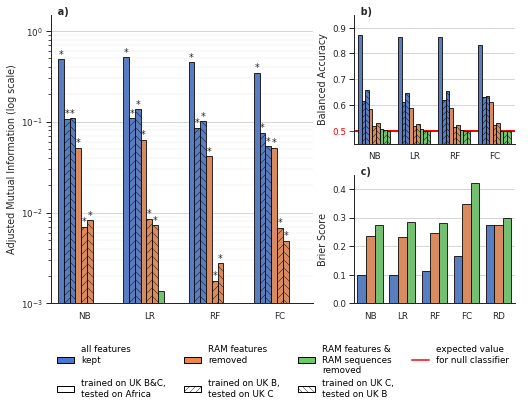

In [49]:
sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
fig = plt.figure(figsize=(8.3, 5.8))
annots_cleaned = ["*" if corrected_cleaned['bonferroni'].get((sub, task, model), False) else "" 
                    for task in task_order for sub in subtypes for model in models]
title_args = {'loc':'left', 'fontweight':'bold', 'pad':0}
ami_ticks = np.linspace(0, 0.55, 12)
acc_ticks = np.linspace(0.5, 0.9, 5)
brier_ticks = np.linspace(0, 0.4, 5)

to_plot_AMI = melted_cleaned[(melted_cleaned['shorthand'].isin(models)) & (melted_cleaned['variable'] == 'AMI')]
to_plot_bal = melted_cleaned[(melted_cleaned['shorthand'].isin(models)) & (melted_cleaned['variable'] == 'bal acc')]
to_plot_brier = scores_proba[(scores_proba['shorthand'].isin(models + ['RD'])) & (scores_proba['subtype'] == 'ALL')]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((12, 5), (0, 0), colspan=3, rowspan=11)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots_cleaned, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True, xlabel="")
    ax2 = plt.subplot2grid((12, 5), (0, 3), colspan=2, rowspan=5)
    ax3 = plt.subplot2grid((12, 5), (6, 3), colspan=2, rowspan=5)
    ax2.axhline(y=0.5, ls='-', color='red', zorder=0.9, lw=2)
    ax2.get_yticklabels()[0].set_color("red")
    ax2.get_yticklines()[0].set_color("red")
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches, ylim=(0.45,0.95), xlabel="")
    get_subplot(to_plot_brier, 'Brier Score', ax=ax3, title='  c)', title_args=title_args, 
                hue_order=[hue_order[i] for i in [0,3,6]], hatches=[], y='brier', palette=sns.color_palette(),
                order=models + ['RD'], ylim=(0, 0.45), yticks=brier_ticks, xlabel="")

ax1.grid(b=True, which='minor', color='.8', lw=0.2)

ax4 = plt.subplot2grid((12, 5), (11, 0), colspan=5)
ax4.axis('off')
ncol, handles = get_legend()
ax4.legend(handles=handles, ncol=ncol,  bbox_to_anchor=(0.5, -0.5), loc='upper center', borderaxespad=0, frameon=False)

plt.subplots_adjust(wspace=0.7)
plt.savefig(os.path.join(dirname, 'perf_log_tight.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
plt.savefig(os.path.join(dirname, 'perf_log_tight.eps'), format='eps', alpha=.99, bbox_inches='tight')